In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/User/github/Quant/data/kospi_category.csv", encoding='cp949')
start_date = '2004-01-01'
end_date = '2020-03-01'
 
df.index = pd.date_range(start_date,end_date,freq='m')
df.drop('date',axis=1, inplace=True)

In [3]:
ret_matrix =  df.values.T

In [4]:
ret_matrix

array([[ 1481.36,  1534.92,  1566.62, ...,  5273.05,  5160.22,  4893.83],
       [ 1301.41,  1273.45,  1258.5 , ...,  3480.12,  3295.05,  3178.68],
       [   87.67,    87.14,    82.87, ...,   289.14,   259.04,   232.81],
       ...,
       [ 1069.3 ,  1121.27,  1064.5 , ...,  1739.59,  1596.21,  1467.8 ],
       [ 5300.97,  5538.77,  5818.82, ..., 13698.26, 12249.88, 11085.54],
       [  355.96,   368.91,   389.92, ...,  1219.07,  1202.74,  1129.52]])

In [5]:
#Generate random weights (무작위 가중치 생성)
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

In [6]:
#Generate a random portfolio (무작위 포트폴리오 생성)
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
 
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma, w

In [7]:
p = np.asmatrix(np.mean(df, axis=1))
w = np.asmatrix(rand_weights(df.shape[0]))
C = np.asmatrix(np.cov(df))

output = []
for i in range(0,10):
  port_mean, port_std, weights = random_portfolio(ret_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

In [ ]:
col_list = list(df.columns)
col_list = [i + '_W' for i in col_list]
 
df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col) 

In [12]:
# 최소분산 포트폴리오
#Minimum variance portfolio (최소 분산 포트폴리오)
'''
min 1/2w'COVw
s.t. mu'w = rp and 1'w = 1
'''
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)
 
  #List of target portfolio returns (목표 포트폴리오 수익률 리스트)
  mus = list(np.arange(0,0.003,0.0001))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list


In [13]:
weights,mean_stds = minimum_port_weight(ret_matrix)
#To dataframe (데이타 프레임으로 변경)
col_name = df.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns=col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

In [14]:
weights_df

,제조업_Weight,음식료품_Weight,섬유의복_Weight,종이목재_Weight,화학_Weight,의약품_Weight,비금속광물_Weight,철강금속_Weight,기계_Weight,전기전자_Weight,...,유통업_Weight,전기가스업_Weight,건설업_Weight,운수창고업_Weight,통신업_Weight,금융업_Weight,은행_Weight,증권_Weight,보험_Weight,서비스업_Weight
0,0.083320,-0.019883,0.282138,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084980,-0.001007,0.672208,0.000237,0.167808,-0.231654,0.165737,-0.029632,0.000315,0.058975
1,0.083320,-0.019883,0.282138,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084980,-0.001007,0.672207,0.000237,0.167808,-0.231654,0.165737,-0.029632,0.000315,0.058975
2,0.083319,-0.019883,0.282138,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084980,-0.001007,0.672207,0.000237,0.167808,-0.231654,0.165737,-0.029632,0.000315,0.058975
3,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084980,-0.001007,0.672207,0.000237,0.167808,-0.231654,0.165737,-0.029632,0.000315,0.058975
4,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084979,-0.001007,0.672207,0.000237,0.167809,-0.231654,0.165737,-0.029632,0.000315,0.058974
5,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084979,-0.001007,0.672206,0.000237,0.167809,-0.231654,0.165737,-0.029632,0.000315,0.058974
6,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084979,-0.001007,0.672206,0.000237,0.167809,-0.231654,0.165737,-0.029632,0.000315,0.058974
7,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084979,-0.001007,0.672206,0.000237,0.167809,-0.231654,0.165737,-0.029632,0.000315,0.058974
8,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084979,-0.001007,0.672206,0.000237,0.167809,-0.231654,0.165737,-0.029632,0.000315,0.058974
9,0.083319,-0.019883,0.282137,0.134490,-0.000731,-0.003608,-0.076782,-0.010707,-0.045652,-0.01232,...,-0.084979,-0.001007,0.672205,0.000237,0.167810,-0.231654,0.165737,-0.029632,0.000315,0.058974


In [15]:
mean_stds_df

,Port_ret,Port_std
0,4.973799e-14,10.222756
1,1.000000e-04,10.222754
2,2.000000e-04,10.222752
3,3.000000e-04,10.222750
4,4.000000e-04,10.222748
5,5.000000e-04,10.222746
6,6.000000e-04,10.222744
7,7.000000e-04,10.222742
8,8.000000e-04,10.222740
9,9.000000e-04,10.222738


Text(0.5, 1.0, 'Minimum variance frontier for risky assets')

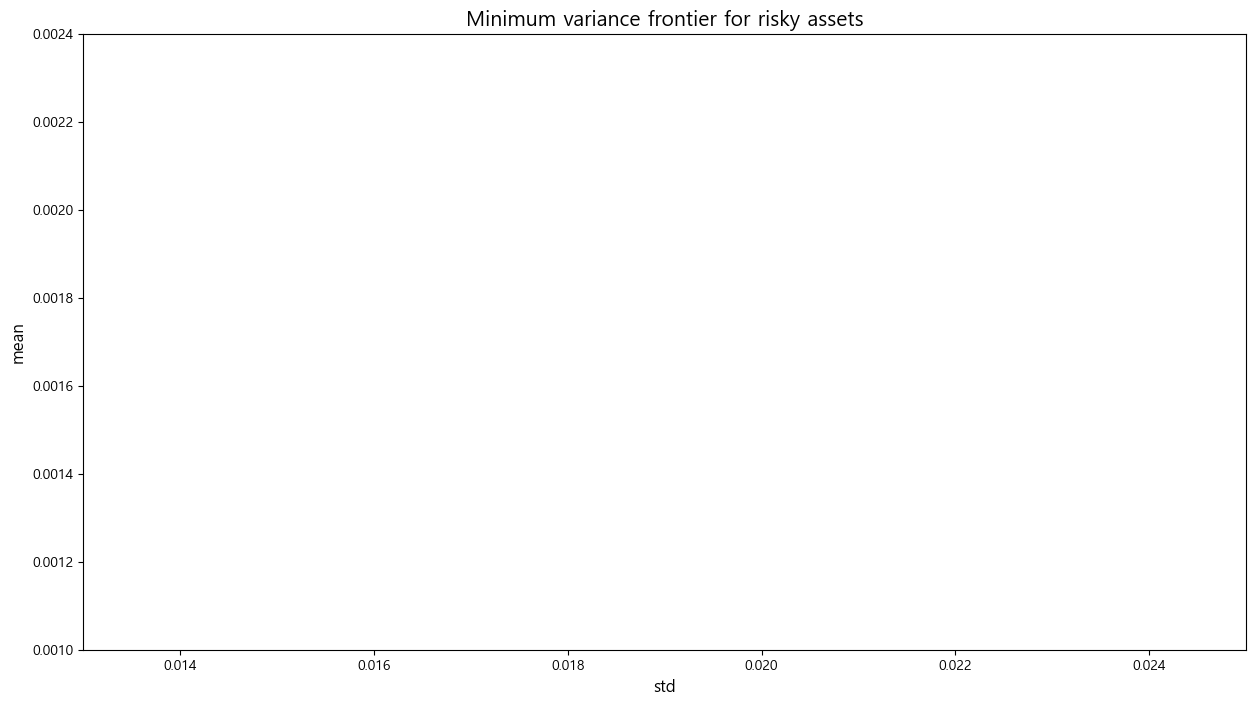

In [16]:
#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
#means = port_ret_var['Port_ret'].values
#stds = port_ret_var['Port_std'].values
 
#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']
 
fig = plt.figure(figsize=(15,8))
#plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o')
plt.xlim(0.013,0.025)
plt.ylim(0.001,0.0024)
plt.title('Minimum variance frontier for risky assets',fontsize=15)
